<a href="https://colab.research.google.com/github/chsk101f/Chemistry/blob/main/spectrum_deconvolution_differential_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


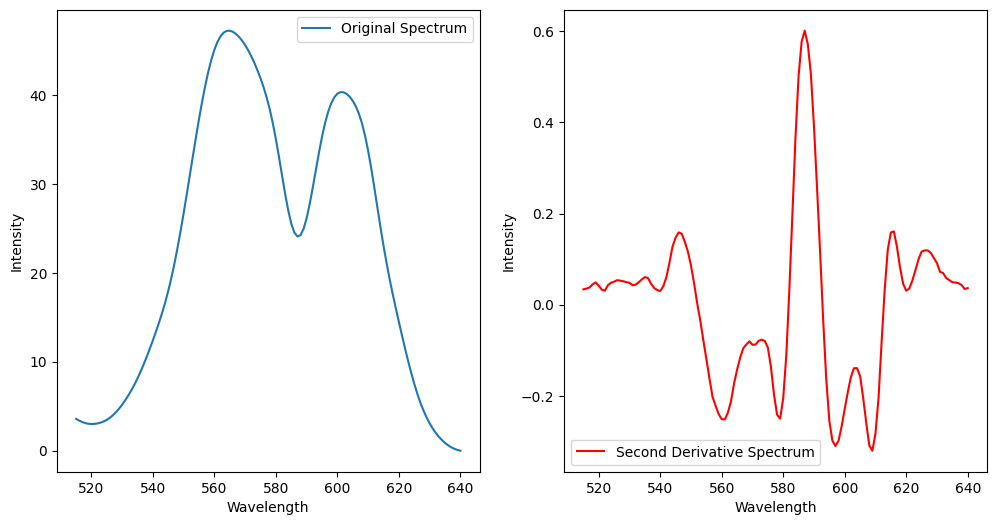

<ipython-input-4-e9ddd3a0ab2a>:9: RuntimeWarning: divide by zero encountered in divide
  z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
<ipython-input-4-e9ddd3a0ab2a>:9: RuntimeWarning: invalid value encountered in divide
  z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
<ipython-input-4-e9ddd3a0ab2a>:10: RuntimeWarning: divide by zero encountered in divide
  return amplitude * wofz(z).real / (sigma * np.sqrt(2 * np.pi))
<ipython-input-4-e9ddd3a0ab2a>:10: RuntimeWarning: invalid value encountered in divide
  return amplitude * wofz(z).real / (sigma * np.sqrt(2 * np.pi))


Optimized Voigt parameters:
Voigt 1: Amplitude=293.8175987002469, Center=595.626748519171, Sigma=5.562559171438885, Gamma=0.051798946814063385
Voigt 2: Amplitude=274.4742174601844, Center=578.949882252213, Sigma=5.855932052882011, Gamma=1.1506206791113769
Voigt 3: Amplitude=148.6153010979085, Center=539.3227699110224, Sigma=0.39661462616301435, Gamma=9.548974160587969
Voigt 4: Amplitude=170.04202732724843, Center=620.5204065132358, Sigma=0.7117966663175146, Gamma=7.507035877888107
Voigt 5: Amplitude=639.2839765384495, Center=606.7848465082678, Sigma=6.889129283199551, Gamma=1.208925301602786
Voigt 6: Amplitude=1420.5318937292368, Center=563.1264108180818, Sigma=10.957264373812745, Gamma=2.0726827392857317


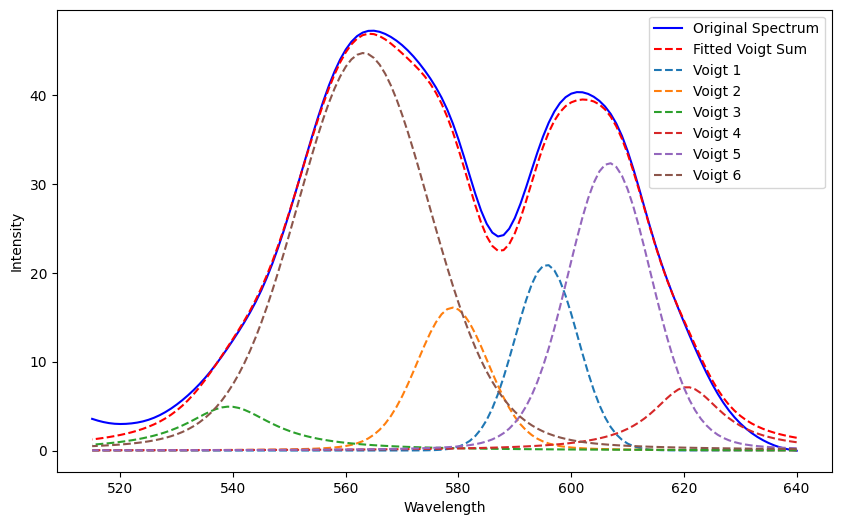

Least squares for original spectrum: 98.99053275111811


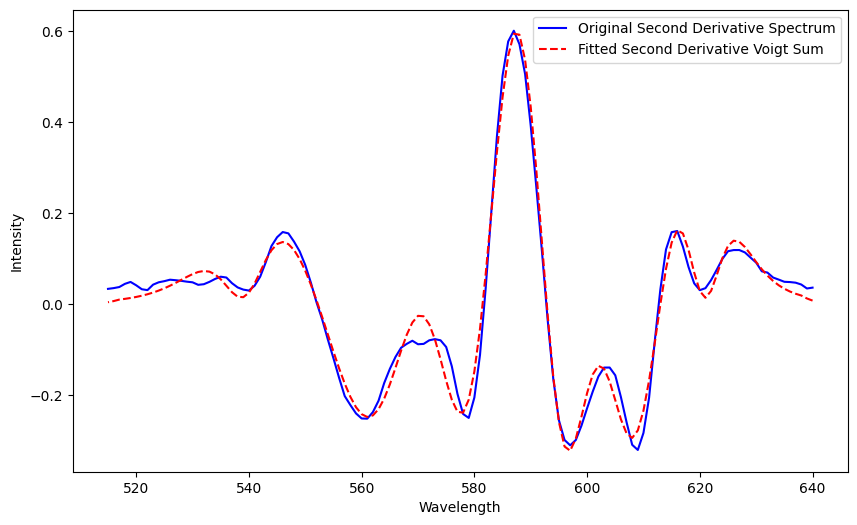

Least squares for second derivative spectrum: 0.09105184848090352
Voigt parameters saved to /content/voigt_parameters.csv


In [ ]:
import numpy as np
from scipy.special import wofz
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# Voigt 함수 정의
def voigt(x, amplitude, center, sigma, gamma):
    z = ((x - center) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * wofz(z).real / (sigma * np.sqrt(2 * np.pi))

# 2차 미분 정의
def second_derivative(y, x):
    dy = np.gradient(y, x)
    d2y = np.gradient(dy, x)
    return d2y

# 스펙트럼 불러오기
def load_spectrum(file_path):
    data = pd.read_csv(file_path)
    x = data.iloc[:, 0].values  # 첫 번째 열
    y = data.iloc[:, 1].values  # 두 번째 열
    return x, y

def load_second_derivative_spectrum(file_path):
    data = pd.read_csv(file_path)
    x = data.iloc[:, 0].values  # 첫 번째 열
    y2 = data.iloc[:, 1].values  # 두 번째 열
    return x, y2

# 시각화 코드
def plot_spectra(x, y, x2, y2):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(x, y, label='Original Spectrum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x2, y2, label='Second Derivative Spectrum', color='r')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()

    plt.show()

# 초기 파라미터 설정
def initialize_voigt_params():
    # 하드코딩된 초기 파라미터 값
    amplitudes = [100, 105, 1000, 250, 200, 1000]
    centers = [530, 560, 580, 600, 620, 640]
    sigmas = [5, 5, 5, 5, 5, 5]
    gammas = [5, 5, 5, 5, 5, 5]

    params = []
    for i in range(6):  # Voigt 함수의 개수를 6개로 설정
        params.append(amplitudes[i])
        params.append(centers[i])
        params.append(sigmas[i])
        params.append(gammas[i])
    return np.array(params)

# Voigt 함수 합과 최소제곱차
def sum_of_voigts(x, *params):
    n = len(params) // 4
    y = np.zeros(len(x), dtype=float)
    individual_voigts = []
    for i in range(n):
        amplitude = params[i * 4]
        center = params[i * 4 + 1]
        sigma = params[i * 4 + 2]
        gamma = params[i * 4 + 3]
        y_voigt = voigt(x, amplitude, center, sigma, gamma)
        y += y_voigt
        individual_voigts.append(y_voigt)
    return y, individual_voigts

# 최소제곱차 계산
def residuals(params, x, y, x2, y2, weight1=0.1, weight2=5000.0):  # 2차 미분 가중치 높임
    y_fit, _ = sum_of_voigts(x, *params)
    y2_fit = second_derivative(y_fit, x)
    res1 = np.sum((y - y_fit)**2)
    res2 = np.sum((y2 - y2_fit)**2)
    return weight1 * res1 + weight2 * res2

# Voigt 함수 피팅 (제약 조건 없이)
def fit_voigts(x, y, x2, y2, initial_params):
    bounds = [(0, 2000), (500, 700), (0, 50), (0, 50)] * 6  # 각 파라미터의 범위 설정
    result = differential_evolution(residuals, bounds, args=(x, y, x2, y2, 0.1, 5000.0), maxiter=2000, popsize=25)
    return result

def plot_fit(x, y, y_fit, individual_voigts):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', label='Original Spectrum')
    plt.plot(x, y_fit, 'r--', label='Fitted Voigt Sum')
    for i, y_voigt in enumerate(individual_voigts):
        plt.plot(x, y_voigt, '--', label=f'Voigt {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

def calculate_least_squares(y, y_fit):
    return np.sum((y - y_fit) ** 2)

def plot_second_derivative_fit(x, y2, y2_fit):
    plt.figure(figsize=(10, 6))
    plt.plot(x, y2, 'b-', label='Original Second Derivative Spectrum')
    plt.plot(x, y2_fit, 'r--', label='Fitted Second Derivative Voigt Sum')
    plt.xlabel('Wavelength')
    plt.ylabel('Intensity')
    plt.legend()
    plt.show()

# CSV 파일로 추출하는 함수
def save_voigt_parameters(x, y_fit, individual_voigts, filename):
    data = {"x": x, "y_fit": y_fit}
    for i, y_voigt in enumerate(individual_voigts):
        data[f"Voigt_{i+1}"] = y_voigt
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Voigt parameters saved to {filename}")

# 전체 흐름
if __name__ == "__main__":
    # 스펙트럼 파일 경로
    original_spectrum_path = '/content/drive/MyDrive/Colab Notebooks/PuISA.csv'
    second_derivative_spectrum_path = '/content/drive/MyDrive/Colab Notebooks/PuISA2nd.csv'

    # 스펙트럼 불러오기
    x, y = load_spectrum(original_spectrum_path)
    x2, y2 = load_second_derivative_spectrum(second_derivative_spectrum_path)

    # 스펙트럼 시각화
    plot_spectra(x, y, x2, y2)

    # Voigt 함수 개수 설정 및 초기 파라미터 설정
    initial_params = initialize_voigt_params()

    # 미분되지 않은 스펙트럼에 대해 Voigt 함수 피팅
    result = fit_voigts(x, y, x2, y2, initial_params)

    # 최적화된 파라미터 추출 및 출력
    popt = result.x
    print("Optimized Voigt parameters:")
    for i in range(len(popt) // 4):
        print(f"Voigt {i+1}: Amplitude={popt[4*i]}, Center={popt[4*i+1]}, Sigma={popt[4*i+2]}, Gamma={popt[4*i+3]}")

    # 피팅 결과 시각화 및 최소제곱차 계산
    y_fit, individual_voigts = sum_of_voigts(x, *popt)
    plot_fit(x, y, y_fit, individual_voigts)
    print(f"Least squares for original spectrum: {calculate_least_squares(y, y_fit)}")

    # 2차 미분된 Voigt 함수 피팅 결과 시각화 및 최소제곱차 계산
    y2_fit = second_derivative(y_fit, x)
    plot_second_derivative_fit(x2, y2, y2_fit)
    print(f"Least squares for second derivative spectrum: {calculate_least_squares(y2, y2_fit)}")

    # Voigt 파라미터 CSV 파일로 추출
    save_voigt_parameters(x, y_fit, individual_voigts, '/content/voigt_parameters.csv')


In [ ]:
from google.colab import files

# CSV 파일로 추출하는 함수 (파라미터 및 스펙트럼)
def save_voigt_parameters_and_spectra(x, y_fit, individual_voigts, filename):
    data = {"x": x, "y_fit": y_fit}
    for i, y_voigt in enumerate(individual_voigts):
        data[f"Voigt_{i+1}"] = y_voigt
    df = pd.DataFrame(data)
    df.to_csv(filename, index=False)
    print(f"Voigt parameters and spectra saved to {filename}")

# 사용 예시
# 최적화된 파라미터를 추출한 후, 이 함수로 데이터를 저장
save_voigt_parameters_and_spectra(x, y_fit, individual_voigts, '/content/voigt_parameters_and_spectra.csv')

# 파일 다운로드
files.download('/content/voigt_parameters_and_spectra.csv')


Voigt parameters and spectra saved to /content/voigt_parameters_and_spectra.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>